## Imports de bibliothèques python

In [1]:
# Imports
import os
working_dir = os.getcwd()

import h5py

# Personal toolboxes
import sys
sys.path.insert(1, './/..//toolboxes')

from utils_plot import * 
from utils_SHanalysis import *
from utils_geometry import * 
from utils_acoustics import *
from theory_spherical_cap import *

import numpy as np
import h5py

# Plots 
import matplotlib.pyplot as plt
%matplotlib widget

## Quelques fonctions utiles pour la suite

In [41]:
def plot_SHspectra(N_SH_axis, SHcoefs_list, ind_k, fig = None, SHcoefs_th = np.array([]), NCC_list = []):
    legend = ['New center', 'Initial']
    if fig == None:
        fig = plt.figure()
    ax_amp = None
    ax_phase = None
    N_method = len(SHcoefs_list)
    for ind_method in range(N_method):
        ax_amp = fig.add_subplot(2,N_method, ind_method + 1, sharex = ax_amp, sharey = ax_amp)
        ax_amp.scatter(N_SH_axis, np.abs(SHcoefs_list[ind_method][:, ind_k]))
        
        # ax_amp.set_title('Method %d'%ind_method)
        ax_amp.set_ylabel('Amplitude')

        ax_phase = fig.add_subplot(2,N_method, ind_method + N_method + 1, sharex = ax_amp, sharey = ax_phase)
        ax_phase.scatter(N_SH_axis, np.angle(SHcoefs_list[ind_method][:, ind_k]))
        ax_phase.set_xlabel('SH order')
        ax_phase.set_ylabel('Phase (radian)')

        if SHcoefs_th.shape[0] != 0:
            if len(NCC_list)!=0:
                ax_amp.set_title('Method %d \n, NCC = %.3f'%(ind_method+1,NCC_list[ind_method][ind_k]))
            ax_amp.scatter(N_SH_axis, np.abs(SHcoefs_th[:,ind_k]), marker = 'x', color = 'r')
            ax_phase.scatter(N_SH_axis, np.angle(SHcoefs_th[:, ind_k]), marker = 'x', color = 'r')
            ampmax = np.max(SHcoefs_list[ind_method][:, ind_k])
            # ax_amp.set_ylim([-0.1*ampmax, ampmax*1.1])
            ax_phase.set_ylim([-np.pi, np.pi])
    plt.tight_layout()
    

def plot_dirballoons(Dinf_list, ind_k,elev = 30, azim = -60, rot= 0, nbtheta_look = 51, nbphi_look = 103,  fig = None, scale = 'dB', dynamic_range = 20, step = 5, legend = '', phase = True):
    if fig == None:
        fig = plt.figure()
    N_method = len(Dinf_list)

    points = np.arange(-dynamic_range, dynamic_range+step, step)

    for ind_method in range(N_method):
        ax = fig.add_subplot(N_method, 1 ,ind_method + 1, projection='3d')
        draw_directivity_balloon(Dinf_list[ind_method][:,ind_k], nbtheta=nbtheta_look, nbphi = nbphi_look, scale = scale, dynamic_range=dynamic_range, ref_sphere= False, ax = ax, phase = phase)
        for point in points :
            ax.text(point, 0, 0, str(np.abs(point)))
            ax.text(0, point, 0, str(np.abs(point)))
            ax.text(0, 0, point, str(np.abs(point)))
        ax.text(30, 0, 0, 'x+')
        ax.text(-30, 0, 0, 'x-')
        
        ax.text(0, 30, 0, 'y+')
        ax.text(0, -30, 0, 'y-')
        ax.text(0, 0, 30, 'z+')
        ax.text(0, 0, -30, 'z-')
        ax.stem3D(points, np.zeros_like(points), np.zeros_like(points), linefmt = 'C1:', markerfmt = 'C0:')
        ax.stem3D(np.zeros_like(points), points, np.zeros_like(points), linefmt = 'C1:', markerfmt = 'C0:')
        ax.stem3D(np.zeros_like(points), np.zeros_like(points), points, linefmt = 'C1:', markerfmt = 'C0:')
        ax.view_init(elev, azim, rot)
        ax.set_axis_off()
        if legend == '' : 
            ax.set_title('Method %d'%ind_method)
        else :
            ax.set_title(legend[ind_method])
            
        plt.tight_layout()

def dB(x) :
    return 20*np.log10(np.abs(x)/np.max(np.abs(x)))

def Dinf_from_meas(x_meas, XYZ_Mems, freqvect, N = 9, nbtheta_look = 51, nbphi_look = 103, lambda_reg = 1e-4) :
    kvect = 2*np.pi*freqvect/c0
    N_SH_vect = compute_N_SH_vect(freqvect, N, rmin = 1.5)
    H_array = compute_SphericalWavesbasis_origin_to_field(XYZ_Mems, kvect, N)
    cmn = compute_SHcoefs(x_meas, H_array, N_SH_vect = N_SH_vect, lambda_reg=lambda_reg)
    angles_look = create_equal_angle_grid(nbtheta_look, nbphi_look)
    Dinf_meas = compute_Dinf_from_SH_coefs_at_origin(cmn,angles_look, kvect)

    return(cmn, Dinf_meas)

def orientation(plan) :
    if plan == 'v' :
        ind_plan = np.hstack((np.arange(51),np.arange(2651,2600,-1)))
        theta = np.linspace(np.pi/2,5/2*np.pi,102)
    elif plan == 'h' :
        hor = []
        for i in range(len(angles_look)) :
            if np.abs(sph2cart(angles_look))[i,2]<1e-3 : hor.append(i)
        ind_plan = hor
        theta = np.linspace(np.pi/2,5/2*np.pi,103)
    else :
        print("Choisir entre le plan vertical ('v') et horizontal ('h')")

    return ind_plan, theta

## Position des micros

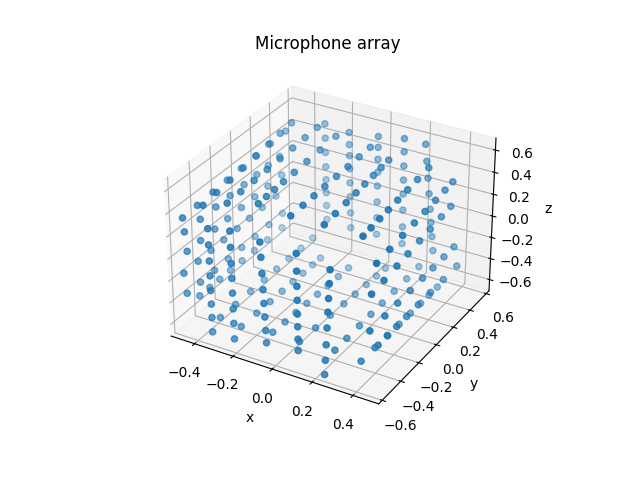

In [3]:
array_file = 'exp_data/calib_geo/XYZm_Calib3_aligne.npz'
XYZ = np.load(array_file)['XYZm'][:-1,:] 

rot_angle = np.pi/2
Ry = np.array([[np.cos(rot_angle),0,np.sin(rot_angle)],[0,1,0],[-np.sin(rot_angle),0,np.cos(rot_angle)]])


# 00cm
# center_source = [-7.5e-2,0,15e-2]
center_source = [-11.5e-2,0,16e-2]          #"Meilleur centre" obtenu avec N=9

ind_samples = [27*8, 12*8, 0, 31*8 + 7, 28*8, 20*8+2 , 2*8, 1*8, 12*8 + 7, 29*8+4, 24*8+3]
XYZ_samples_ref = np.array([[50,30,53], 
                    [-67,-39, -21],
                    [-49, 54, 45],
                    [28,-50,-29],
                    [24, -61, 42],
                    [0,-60,-13],
                    [50,25,-22],
                    [-65,-41,53],
                    [-66,40,-5],
                    [-23,0,-29],
                    [-4,-4,60]], dtype = float)*1e-2

XYZ_ref_retrieved = XYZ[ind_samples[2],:]
XYZ_ref_real = XYZ_samples_ref[2,:]

XYZ[:,1] *=-1
XYZ_centered  = XYZ - XYZ_ref_retrieved + XYZ_ref_real

XYZ_Mems = XYZ_centered[:-1,:]-center_source
XYZ_Mems = XYZ_Mems@Ry                      #Rotation z->x : Calotte dirigée vers les z positifs

plot_array(XYZ_Mems)


## Chargement des mesures

In [4]:
# Paramètres fréquentiels
freqvect = np.arange(100, 5001, 10) # Hz
N_freq = len(freqvect)
c0 = 343 # m/s
kvect = 2*np.pi*freqvect/c0 

eta = 3



source_folder = './exp_data/DataCalotte_00cm/'
input_file = 'mu5h-20230517-150510.h5'

data = h5py.File(source_folder + input_file,'r') #working_dir + source_folder + input_file, 'r')  
    
Secs = [int(i) for i in data['muh5'].keys()] 
NbSecs = len(data['muh5'].keys())

Sig = np.concatenate([data['muh5'][str(i)]['sig'][:] for i in range(NbSecs)], axis=1)

fs = 50e3
Nsamples = int(NbSecs*fs)
ind_Mems_ref = 4*8+3
vectf = np.fft.rfftfreq(Nsamples, 1/fs)
ind_freq_study = []
for ind_freq in range(len(freqvect)):
    ind_freq_study.append(np.argmin(np.abs(freqvect[ind_freq] - vectf)))

Mems = Sig[1:257,:]
Ref = Sig[257:,:]
SRef = np.fft.rfft(Ref, axis = 1)
SMems = np.fft.rfft(Mems)
TF_Memsref_Memsi = SMems/SMems[ind_Mems_ref,:]
x_meas = TF_Memsref_Memsi[:,ind_freq_study]


## Spectres

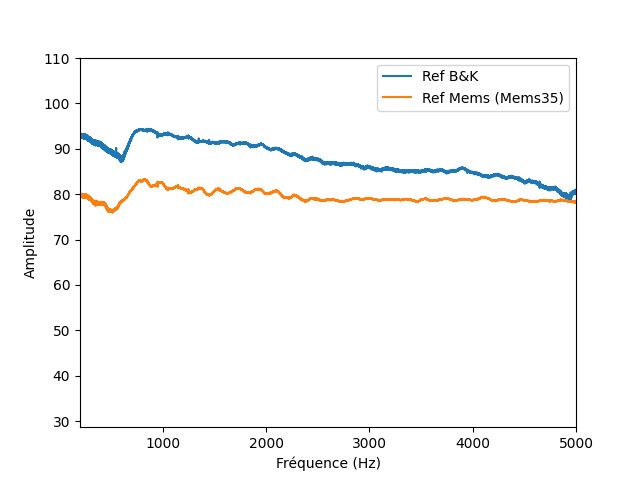

In [5]:
plt.figure()
plt.plot(vectf, 10*np.log10(np.abs(SRef[1].T)))
plt.plot(vectf, 10*np.log10(np.abs(SMems[4*8+3].T)))
plt.xlim([200,5000])
plt.xlabel('Fréquence (Hz)')
plt.ylabel('Amplitude')
plt.legend(['Ref B&K',f'Ref Mems (Mems{ind_Mems_ref})'])

Spectrogramme

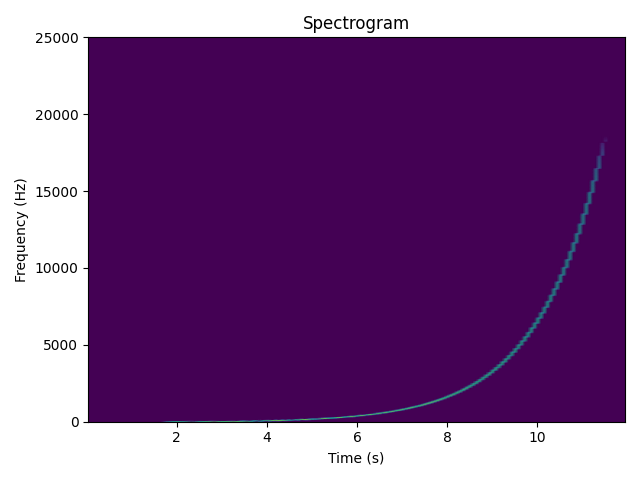

In [6]:
import scipy.signal
f_spectro, t_spectro, spectro_ref = scipy.signal.spectrogram(Ref[0], fs = fs, nperseg = 2**12)
DR = 80
spectro_ref = spectro_ref.squeeze()
spectro_ref_dB = 20*np.log10(spectro_ref/spectro_ref.max())
spectro_ref_dB[spectro_ref_dB< -DR] = -DR 
fig = plt.figure()
plt.pcolormesh(t_spectro, f_spectro, spectro_ref_dB, shading='gouraud')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.title('Spectrogram')
plt.tight_layout()

## Directivité théorique

In [22]:
r_sphere = 8.5e-2
r_opening = 4e-2
theta_0 = np.arctan(r_opening/r_sphere)
rho0 = 1.293
angles_look = create_equal_angle_grid(51,103)

N_SH_th = 6        #Ordre max pour les coefficients SH

# compute axis-symetrical SH coefficients of the pressure at origin
SHcoefs_velocity_on_baffle = -1j*rho0*c0*comp_SHcoefs_velocity_on_baffle_piston_sphericalbaffle(kvect, r_sphere = r_sphere, r_opening = r_opening, N_SH_max = N_SH_max, Wdot = 1)
SH_orders = np.arange(N_SH_th+1, dtype = int)
SHcoefs_pressure = SHcoefs_velocity_on_baffle[:,np.newaxis]/spherical_hn_diff(SH_orders[:,np.newaxis],kvect[np.newaxis,:]*r_sphere) # SH coefs of the pressure at the origin (cmn)
# transform axis-symmetrical SH coefficients into classical SH ones
SH_th = np.zeros(((N_SH_th+1)**2, N_freq), dtype = complex)
for ind_SH in range(N_SH_th):
    alpha_n = np.sqrt(4*np.pi/(2*ind_SH+1))
    SH_th[ind_SH**2 + ind_SH,:] = SHcoefs_pressure[ind_SH,:]*alpha_n # Y_{nm}(\theta, \phi)                                         #SH coefs

Dinf_th = np.array([comp_dir(f,50,angles_look[:,0], R = r_sphere, c0 = c0, rho0 = rho0, theta_0 = theta_0) for f in freqvect]).T    #Directivité

## NCC/Ordre de troncature

c:\Users\augus\Desktop\Stage_augustin\notebooks\utils_SHanalysis.py:221: RuntimeWarning: divide by zero encountered in divide
  kr_farfield = eta*(scsp.factorial(2*n_SH_vect)/(2**n_SH_vect*scsp.factorial(n_SH_vect)))**(1/n_SH_vect) # check eqs 7 8 Hartenstein et al FA 2023


1
2
3
4
5
6
7
8
9
10


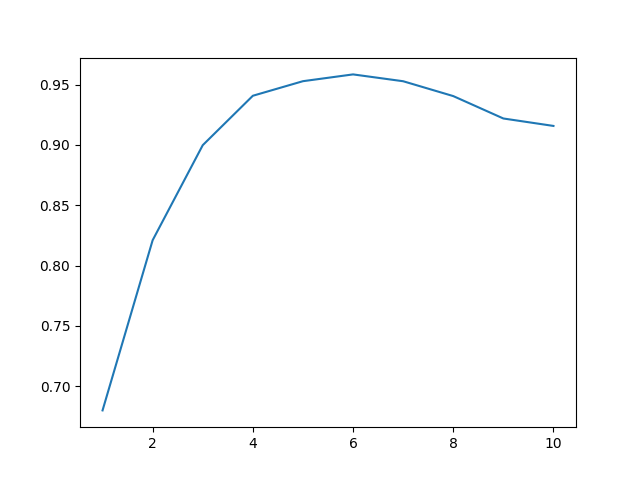

In [23]:
SH_dic = {}
Dinf_dic = {}

N_max = 11              #Range des ordres de troncature

for N in range(1,N_max) :
    SH_dic[N], Dinf_dic[N] = Dinf_from_meas(x_meas, XYZ_Mems, freqvect, N=N)
    print(N)

c = []
for n in range(1,N_max) :  
    c.append(np.mean(compute_NCC(Dinf_dic[n],Dinf_th)))     #Plus propre en corrélation spatiale, mais il manque les poids 
    # c.append(np.mean(compute_NCC(SH_dic[n],SH_th)))       #Peut-être augmenter N_SH_th pour la théorie
plt.figure()
plt.plot(range(1,N_max),c)

## Calcul de directivité

In [46]:
N = 6
cmn, Dinf = Dinf_from_meas(x_meas, XYZ_Mems, freqvect, N=N)

c:\Users\augus\Desktop\Stage_augustin\notebooks\utils_SHanalysis.py:221: RuntimeWarning: divide by zero encountered in divide
  kr_farfield = eta*(scsp.factorial(2*n_SH_vect)/(2**n_SH_vect*scsp.factorial(n_SH_vect)))**(1/n_SH_vect) # check eqs 7 8 Hartenstein et al FA 2023


### Comparaison entre théorie et reconstruction des spectres SH

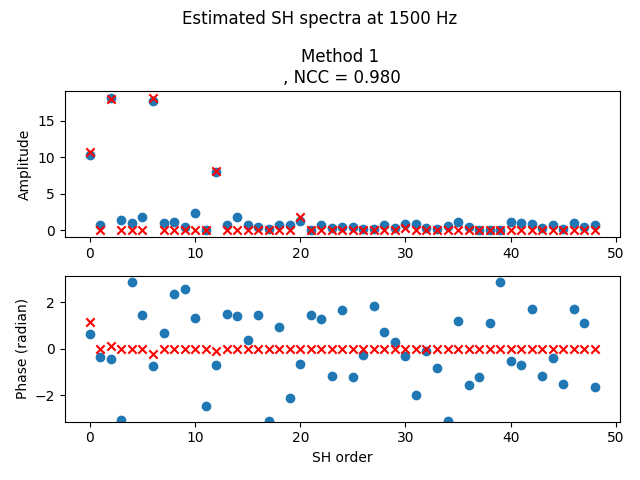

In [36]:
# Analyse des résultats
N_SH_axis = np.arange((N+1)**2, dtype = float)

f = 1500
ind_k = np.argmin(np.abs(f-freqvect))

NCC = compute_NCC(cmn, SH_th)

fig = plt.figure()
fig.suptitle('Estimated SH spectra at %d Hz'%freqvect[ind_k])
plot_SHspectra(N_SH_axis, cmn[np.newaxis,:], ind_k, fig, SHcoefs_th=SH_th/np.max(np.abs(SH_th[:,ind_k]))*np.max(np.abs(cmn[:,ind_k])), NCC_list = NCC[np.newaxis,:])

### Comparaison entre théorie et estimation de directivité

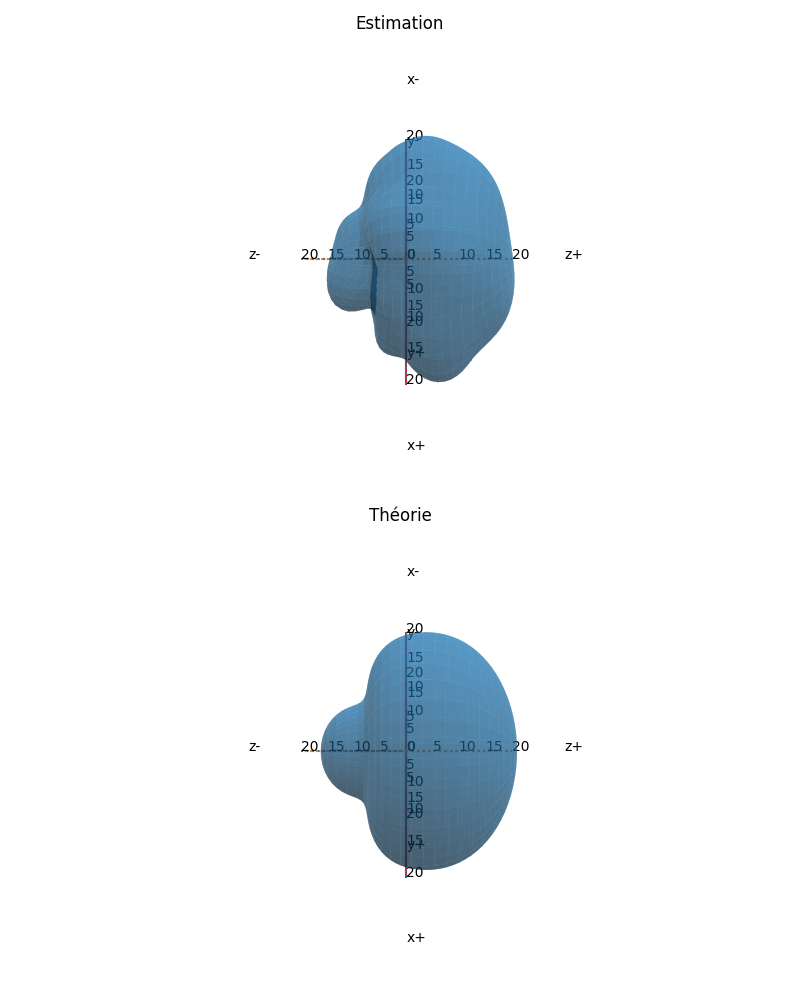

In [40]:
D_plot = [Dinf, Dinf_th]  #Liste des directivité à tracer

fig = plt.figure(figsize = (8,10))
plot_dirballoons(D_plot, ind_k, elev=0, rot= -90, fig = fig, legend = ['Estimation','Théorie'],phase = False)


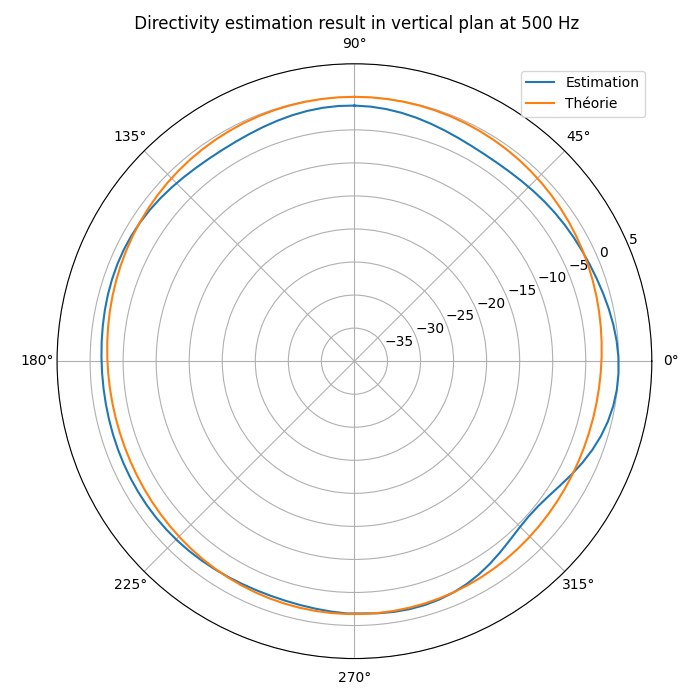

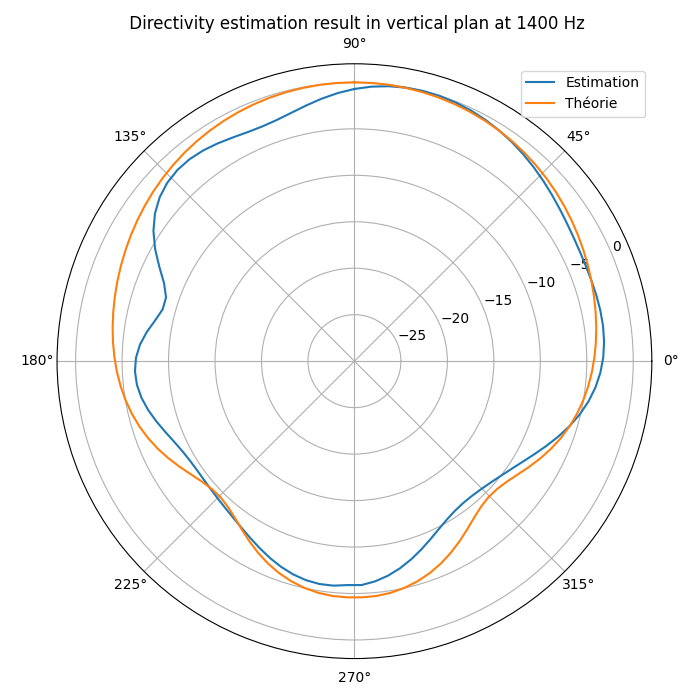

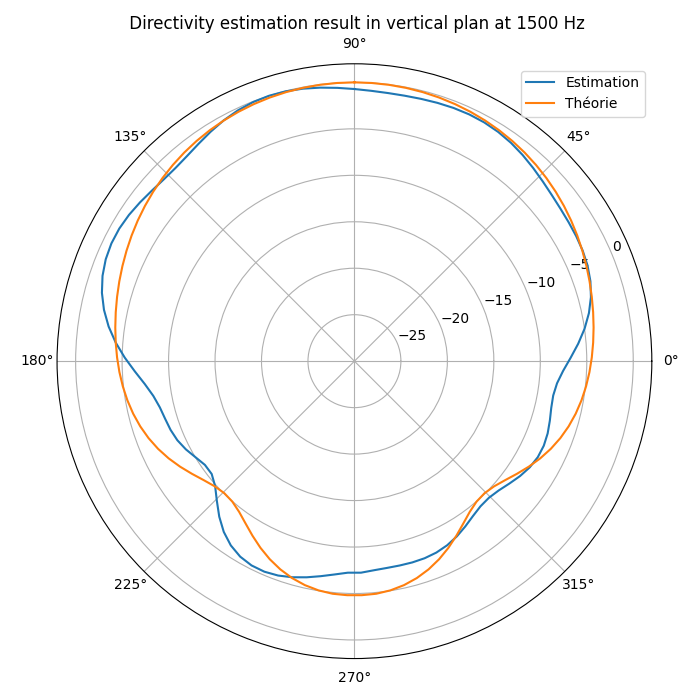

In [42]:
angles_look = create_equal_angle_grid(51,103)

(plan, theta) = orientation('v') #Choix du plan vertical ou horizontal

freqplot = [500,1400,1500]


for f in freqplot :
    ind_f = np.argmin(np.abs(f-freqvect))
    fig = plt.figure(figsize= (7,7))
    ax = fig.add_subplot(1, 1, 1, projection = 'polar')
    for Dinf in D_plot :
        ax.plot(theta, dB(Dinf[plan,ind_f]))
    ax.legend(['Estimation', 'Théorie'])
    ax.set_title(f" Directivity estimation result in vertical plan at {f} Hz")

    if f>1000 : (rmin,rmax) = (-30,2)
    else : (rmin, rmax) = (-40, 5)
    ax.set_rmax(rmax)
    ax.set_rmin(rmin)
    plt.tight_layout()

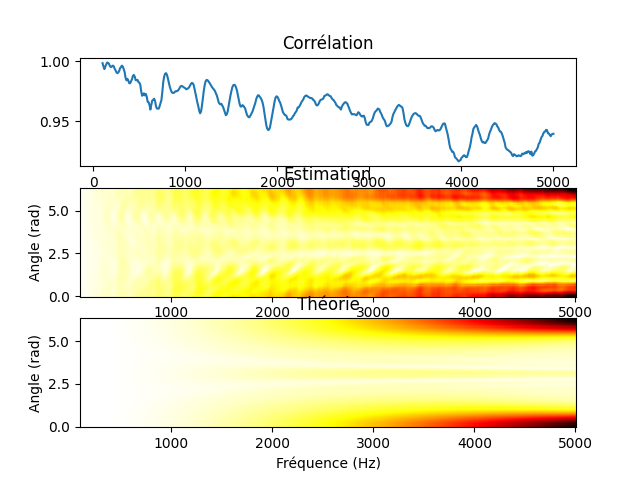

In [48]:
(plan, theta) = orientation('v')


cor_plan = compute_NCC(Dinf[plan],Dinf_th[plan])  #Corrélation dans le plan

fig, ax = plt.subplots(3,1)
ax[0].plot(freqvect,cor_plan.T)
ax[0].set_title('Corrélation')
colorplot = np.abs(Dinf[plan])
cs = ax[1].pcolor(freqvect,theta-np.pi/2,colorplot, cmap = 'hot_r')
ax[1].set_title('Estimation')
ax[1].set_ylabel('Angle (rad)')
colorplot = np.abs(Dinf_th[plan])
ax[2].set_title('Théorie')
ax[2].set_ylabel('Angle (rad)')
ax[2].set_xlabel('Fréquence (Hz)')
cs = ax[2].pcolor(freqvect,theta-np.pi/2,colorplot, cmap = 'hot_r')